# Dataset về đề xuất nhạc trong ô tô có tính đến ngữ cảnh


### Import các thư viện cần thiết

In [59]:
pip install numpy pandas matplotlib seaborn openpyxl tensorflow scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl

# Thiết lập hiển thị
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('default')
sns.set_palette('husl')

### Đọc dữ liệu từ file Excel

In [61]:
# Đọc file Excel từ nhiều sheet như trong exploration notebook
con_rat = pd.read_excel('./Data_InCarMusic.xlsx', sheet_name=0).rename(columns={' Rating': 'label', 'UserID': 'user', 'ItemID': 'item'})
con_fac = pd.read_excel('./Data_InCarMusic.xlsx', sheet_name=1)
mus_trk = pd.read_excel('./Data_InCarMusic.xlsx', sheet_name=2).rename(columns={' category_id': 'category_id'})
mus_cat = pd.read_excel('./Data_InCarMusic.xlsx', sheet_name=3, header=None).rename(columns={0:'genre_id', 1:'genre'})

# Tạo dictionary cho genre mapping
mus_cat_dict = mus_cat.set_index('genre_id').genre.str.split(' ').str[0].to_dict()
mus_trk['genre'] = mus_trk.category_id.apply(lambda x: mus_cat_dict.get(x))

# Sử dụng con_rat làm dataframe chính
df = con_rat.copy()

print(f'\nKích thước dữ liệu: {df.shape[0]} hàng x {df.shape[1]} cột')
print(f'Các cột: {list(df.columns)}')



Kích thước dữ liệu: 4012 hàng x 11 cột
Các cột: ['user', 'item', 'label', 'DrivingStyle', 'landscape', 'mood', 'naturalphenomena ', 'RoadType', 'sleepiness', 'trafficConditions', 'weather']


## Tiền xử lý dữ liệu

In [62]:
# Tìm các cột context (categorical)
cat_cols = df.columns[df.dtypes == 'object']
print("Các cột context:", list(cat_cols))

# In ra các giá trị unique cho mỗi cột context
print("\nCác giá trị unique cho mỗi cột context:")
for c in cat_cols:
    unique_vals = df[c].unique()
    print(f'{str(unique_vals):<55} #{len(unique_vals)}')

# Tạo binary label như trong exploration
df['label'] = np.select([df.label > 3, df.label <= 3], [1, 0])

# Xử lý missing values - thay thế NaN bằng 'Unknown' thay vì loại bỏ
for col in cat_cols:
    df[col] = df[col].fillna('Unknown')

print(f"\nSau khi xử lý missing values:")
print(f"Số dòng: {len(df)}")
print(f"Số user: {df['user'].nunique()}")
print(f"Số item: {df['item'].nunique()}")


Các cột context: ['DrivingStyle', 'landscape', 'mood', 'naturalphenomena ', 'RoadType', 'sleepiness', 'trafficConditions', 'weather']

Các giá trị unique cho mỗi cột context:
[nan 'relaxed driving' 'sport driving']                 #3
[nan 'urban' 'mountains' 'country side' 'coast line']   #5
[nan 'sad' 'lazy' 'active' 'happy']                     #5
[nan 'night' 'morning' 'day time' 'afternoon']          #5
[nan 'city' 'serpentine' 'highway']                     #4
[nan 'sleepy' 'awake']                                  #3
[nan 'traffic jam' 'lots of cars' 'free road']          #4
['sunny' 'snowing' 'rainy' 'cloudy' nan]                #5

Sau khi xử lý missing values:
Số dòng: 4012
Số user: 42
Số item: 139


In [63]:
# Xử lý context với one-hot encoding như trong exploration notebook
# Tạo one-hot encoding cho các cột context
features_oh = pd.get_dummies(df[cat_cols], dummy_na=True)

# Tạo context string từ one-hot encoding
context_series = (features_oh * features_oh.columns).sum(axis=1)
context_series.rename('context', inplace=True)

# Tạo dataframe cuối cùng với context
feat_data = pd.concat([df[['user', 'item', 'label']], context_series], axis=1)

print("Dataframe sau khi xử lý context:")
print(feat_data.head())
print(f"\nSố lượng context unique: {feat_data['context'].nunique()}")
print(f"Các context mẫu: {feat_data['context'].unique()[:10]}")


Dataframe sau khi xử lý context:
   user  item  label                                            context
0  1001   715      0  DrivingStyle_Unknownlandscape_Unknownmood_Unkn...
1  1001   267      1  DrivingStyle_Unknownlandscape_Unknownmood_Unkn...
2  1001   294      0  DrivingStyle_Unknownlandscape_Unknownmood_Unkn...
3  1001   259      1  DrivingStyle_Unknownlandscape_Unknownmood_Unkn...
4  1001   674      0  DrivingStyle_Unknownlandscape_Unknownmood_Unkn...

Số lượng context unique: 27
Các context mẫu: ['DrivingStyle_Unknownlandscape_Unknownmood_Unknownnaturalphenomena _UnknownRoadType_Unknownsleepiness_UnknowntrafficConditions_Unknownweather_sunny'
 'DrivingStyle_Unknownlandscape_Unknownmood_Unknownnaturalphenomena _UnknownRoadType_Unknownsleepiness_UnknowntrafficConditions_Unknownweather_snowing'
 'DrivingStyle_Unknownlandscape_Unknownmood_Unknownnaturalphenomena _UnknownRoadType_Unknownsleepiness_UnknowntrafficConditions_Unknownweather_rainy'
 'DrivingStyle_Unknownlandscape_Unkno

In [64]:
# Xuất dữ liệu 
import os
out_dir = 'output_carskit'
os.makedirs(out_dir, exist_ok=True)

# Xuất ratings với context (cho LightFM)
ratings_ctx_path = os.path.join(out_dir, 'ratings_with_context.csv')
feat_data.to_csv(ratings_ctx_path, index=False, encoding='utf-8')

# Xuất ratings chỉ có user, item, label (cho collaborative filtering)
ratings_only = feat_data[['user', 'item', 'label']].copy()
ratings_only_path = os.path.join(out_dir, 'ratings_only.csv')
ratings_only.to_csv(ratings_only_path, index=False, encoding='utf-8')

# Xuất thông tin item với genre (cho item features)
item_features = mus_trk[['id', 'genre']].rename(columns={'id': 'item'})
item_features_path = os.path.join(out_dir, 'item_features.csv')
item_features.to_csv(item_features_path, index=False, encoding='utf-8')

print("Đã lưu các file:")
print(f" - {ratings_ctx_path}")
print(f" - {ratings_only_path}")
print(f" - {item_features_path}")

# Thống kê cuối cùng
print(f"\nThống kê cuối cùng:")
print(f"Số user: {feat_data['user'].nunique()}")
print(f"Số item: {feat_data['item'].nunique()}")
print(f"Số interaction: {len(feat_data)}")
print(f"Số context unique: {feat_data['context'].nunique()}")
print(f"Tỷ lệ positive (label=1): {feat_data['label'].mean():.3f}")


Đã lưu các file:
 - output_carskit\ratings_with_context.csv
 - output_carskit\ratings_only.csv
 - output_carskit\item_features.csv

Thống kê cuối cùng:
Số user: 42
Số item: 139
Số interaction: 4012
Số context unique: 27
Tỷ lệ positive (label=1): 0.258


## Train mô hình gợi ý

In [65]:
import os
import numpy as np
import pandas as pd
from collections import defaultdict

import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from models.model_classes import BMF, NeuMF, LNCM, ENCM

DATA_DIR = r"D:\DATN-CNTT-2025-CoLien-B21DCCN433\Demo\output_carskit"
RATINGS_ONLY = os.path.join(DATA_DIR, "ratings_only.csv")
RATINGS_CTX = os.path.join(DATA_DIR, "ratings_with_context.csv")

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

df_only = pd.read_csv(RATINGS_ONLY)          # columns: user, item, label
df_ctx = pd.read_csv(RATINGS_CTX)            # columns: user, item, label, context (string)

# Binary labels already prepared in your pipeline (0/1)
df_only = df_only.astype({"user": str, "item": str, "label": int})
df_ctx = df_ctx.astype({"user": str, "item": str, "label": int, "context": str})

print(df_only.head())
print(df_ctx.head())
print("Users:", df_only["user"].nunique(), "Items:", df_only["item"].nunique(), "Interactions:", len(df_only))

   user item  label
0  1001  715      0
1  1001  267      1
2  1001  294      0
3  1001  259      1
4  1001  674      0
   user item  label                                            context
0  1001  715      0  DrivingStyle_Unknownlandscape_Unknownmood_Unkn...
1  1001  267      1  DrivingStyle_Unknownlandscape_Unknownmood_Unkn...
2  1001  294      0  DrivingStyle_Unknownlandscape_Unknownmood_Unkn...
3  1001  259      1  DrivingStyle_Unknownlandscape_Unknownmood_Unkn...
4  1001  674      0  DrivingStyle_Unknownlandscape_Unknownmood_Unkn...
Users: 42 Items: 139 Interactions: 4012


In [66]:
user_le = LabelEncoder().fit(df_only["user"].values)
item_le = LabelEncoder().fit(df_only["item"].values)

# Use the combined 'context' string as one categorical feature for ENCM
ctx_le = LabelEncoder().fit(df_ctx["context"].values)

df_only["u_idx"] = user_le.transform(df_only["user"])
df_only["i_idx"] = item_le.transform(df_only["item"])

df_ctx["u_idx"] = user_le.transform(df_ctx["user"])
df_ctx["i_idx"] = item_le.transform(df_ctx["item"])
df_ctx["c_idx"] = ctx_le.transform(df_ctx["context"])

n_users = df_only["u_idx"].max() + 1
n_items = df_only["i_idx"].max() + 1
n_contexts = [df_ctx["c_idx"].max() + 1]  # single context field

n_users, n_items, n_contexts

def per_user_split(df, user_col="u_idx", frac_test=0.2, frac_val=0.1, seed=SEED):
    train_rows, test_rows = [], []
    for u, grp in df.groupby(user_col):
        if len(grp) < 2:
            train_rows.append(grp)
            continue
        tr, te = train_test_split(grp, test_size=frac_test, random_state=seed, shuffle=True)
        train_rows.append(tr)
        test_rows.append(te)
    train_df = pd.concat(train_rows).reset_index(drop=True)
    test_df = pd.concat(test_rows).reset_index(drop=True) if test_rows else train_df.iloc[0:0].copy()

    # val from train
    if len(train_df) > 1:
        tr_rows, val_rows = [], []
        for u, grp in train_df.groupby(user_col):
            if len(grp) < 2:
                tr_rows.append(grp)
                continue
            tr, va = train_test_split(grp, test_size=frac_val, random_state=seed, shuffle=True)
            tr_rows.append(tr)
            val_rows.append(va)
        train_df = pd.concat(tr_rows).reset_index(drop=True)
        val_df = pd.concat(val_rows).reset_index(drop=True) if val_rows else train_df.iloc[0:0].copy()
    else:
        val_df = train_df.iloc[0:0].copy()

    return train_df, val_df, test_df

train_only, val_only, test_only = per_user_split(df_only)
train_ctx,  val_ctx,  test_ctx  = per_user_split(df_ctx)

len(train_only), len(val_only), len(test_only), len(train_ctx), len(val_ctx), len(test_ctx)

(2863, 341, 808, 2863, 341, 808)

In [67]:
def build_user_positives(df, user_col="u_idx", item_col="i_idx", label_col="label"):
    pos = defaultdict(set)
    for u, it, y in df[[user_col, item_col, label_col]].itertuples(index=False):
        if y == 1:
            pos[u].add(it)
    return pos

train_pos = build_user_positives(train_only)
all_items = np.arange(n_items, dtype=np.int32)

# Increase negatives for harder training
DEF_NUM_NEG = 10

def make_pairs(df, user_col="u_idx", item_col="i_idx", label_col="label", num_neg=DEF_NUM_NEG):
    users, items, labels = [], [], []
    by_user = df.groupby(user_col)
    for u, grp in by_user:
        pos_items = set(grp.loc[grp[label_col] == 1, item_col].tolist())
        if not pos_items:
            continue
        for it in pos_items:
            users.append(u); items.append(it); labels.append(1)
            # Negatives
            neg_count = 0
            while neg_count < num_neg:
                j = np.random.randint(0, n_items)
                if (j not in pos_items):
                    users.append(u); items.append(j); labels.append(0)
                    neg_count += 1
    return np.array(users, dtype=np.int32), np.array(items, dtype=np.int32), np.array(labels, dtype=np.float32)

tr_u, tr_i, tr_y = make_pairs(train_only)
va_u, va_i, va_y = make_pairs(val_only) if len(val_only) else (tr_u[:0], tr_i[:0], tr_y[:0])

In [68]:
# Tạo tf.data.Dataset cho mô hình 2-input (BMF/NeuMF/LNCM) và 3-input (ENCM)
import tensorflow as tf
import numpy as np

BATCH_SIZE = 256
SHUFFLE_BUF = 100_000

# 2-input datasets: (user_idx, item_idx) -> label
train_ds_2 = tf.data.Dataset.from_tensor_slices(((tr_u, tr_i), tr_y)) \
    .shuffle(min(len(tr_y), SHUFFLE_BUF), seed=SEED, reshuffle_each_iteration=True) \
    .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds_2 = tf.data.Dataset.from_tensor_slices(((va_u, va_i), va_y)) \
    .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 3-input datasets cho ENCM: (user_idx, item_idx, context_idx[None]) -> label
# Tạo cặp có ngữ cảnh từ tập đã có c_idx (train_ctx/val_ctx)
from collections import defaultdict

def make_pairs_with_ctx(df, user_col="u_idx", item_col="i_idx", ctx_col="c_idx", label_col="label", num_neg=DEF_NUM_NEG):
    users, items, ctxs, labels = [], [], [], []
    by_user = df.groupby(user_col)
    for u, grp in by_user:
        pos_rows = grp.loc[grp[label_col] == 1, [item_col, ctx_col]]
        pos_items = set(pos_rows[item_col].tolist())
        if not len(pos_rows):
            continue
        for it, c in pos_rows.itertuples(index=False):
            # positive
            users.append(u); items.append(it); ctxs.append(c); labels.append(1.0)
            # negatives với cùng context của positive để giữ ngữ cảnh ổn định
            neg_count = 0
            while neg_count < num_neg:
                j = np.random.randint(0, n_items)
                if j not in pos_items:
                    users.append(u); items.append(j); ctxs.append(c); labels.append(0.0)
                    neg_count += 1
    return (
        np.array(users, dtype=np.int32),
        np.array(items, dtype=np.int32),
        np.array(ctxs, dtype=np.int32),
        np.array(labels, dtype=np.float32),
    )

tr_u3, tr_i3, tr_c3, tr_y3 = make_pairs_with_ctx(train_ctx)
va_u3, va_i3, va_c3, va_y3 = make_pairs_with_ctx(val_ctx) if len(val_ctx) else (tr_u3[:0], tr_i3[:0], tr_c3[:0], tr_y3[:0])

# reshape context sang (N, 1) như ENCM.build([(None,), (None,), (None, 1)])
tr_c3_inp = tr_c3.reshape(-1, 1)
va_c3_inp = va_c3.reshape(-1, 1)

train_ds_3 = tf.data.Dataset.from_tensor_slices(((tr_u3, tr_i3, tr_c3_inp), tr_y3)) \
    .shuffle(min(len(tr_y3), SHUFFLE_BUF), seed=SEED, reshuffle_each_iteration=True) \
    .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds_3 = tf.data.Dataset.from_tensor_slices(((va_u3, va_i3, va_c3_inp), va_y3)) \
    .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Lưu train_encm để sử dụng ở phần builder đánh giá top-K (lấy mode context per-user)
train_encm = train_ctx[["u_idx", "i_idx", "c_idx", "label"]].copy()

In [69]:
def compile_binary(model, lr=1e-3):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=[tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.BinaryAccuracy(name="acc")]
    )

def fit_model(model, train_ds, val_ds, epochs=5):
    cb = [
        tf.keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=2, restore_best_weights=True)
    ]
    hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=1, callbacks=cb)
    return hist

In [86]:
bmf = BMF(n_users=n_users, n_items=n_items, embedding_dim=50)
# build shapes
bmf.build([(None,), (None,)])
compile_binary(bmf, lr=1e-3)
fit_model(bmf, train_ds_2, val_ds_2, epochs=15)

Epoch 1/15


c:\Users\Admin\miniconda3\Lib\site-packages\keras\src\layers\layer.py:424: UserWarning: `build()` was called on layer 'bmf_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - acc: 0.7395 - auc: 0.5185 - loss: 0.6762 - val_acc: 0.8844 - val_auc: 0.5364 - val_loss: 0.6554
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9020 - auc: 0.5679 - loss: 0.6401 - val_acc: 0.9078 - val_auc: 0.5439 - val_loss: 0.6217
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9091 - auc: 0.5992 - loss: 0.6031 - val_acc: 0.9091 - val_auc: 0.5454 - val_loss: 0.5853
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9091 - auc: 0.6181 - loss: 0.5601 - val_acc: 0.9091 - val_auc: 0.5549 - val_loss: 0.5418
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9091 - auc: 0.6421 - loss: 0.5077 - val_acc: 0.9091 - val_auc: 0.5620 - val_loss: 0.4920
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9091 - auc: 0.6593 - loss: 0.4506 - val_acc: 0.9091 - val_auc: 0.5682 - val_loss: 0.4433
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.9091 - auc: 0.6733 - loss: 0.3983 - val_acc: 0.9091 - val_auc: 

In [87]:
neumf = NeuMF(n_users=n_users, n_items=n_items, embedding_dim=50, hidden_dims=[64,32,16])
neumf.build([(None,), (None,)])
compile_binary(neumf, lr=1e-3)
fit_model(neumf, train_ds_2, val_ds_2, epochs=15)

Epoch 1/15


c:\Users\Admin\miniconda3\Lib\site-packages\keras\src\layers\layer.py:424: UserWarning: `build()` was called on layer 'neu_mf_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - acc: 0.8801 - auc: 0.4989 - loss: 0.6669 - val_acc: 0.9091 - val_auc: 0.4955 - val_loss: 0.6173
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.9091 - auc: 0.4885 - loss: 0.5397 - val_acc: 0.9091 - val_auc: 0.5112 - val_loss: 0.4128
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.9091 - auc: 0.5304 - loss: 0.3515 - val_acc: 0.9091 - val_auc: 0.5236 - val_loss: 0.3227
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.9091 - auc: 0.5576 - loss: 0.3228 - val_acc: 0.9091 - val_auc: 0.5576 - val_loss: 0.3071
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.9091 - auc: 0.5999 - loss: 0.3074 - val_acc: 0.9091 - val_auc: 0.5843 - val_loss: 0.3047
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.9091 - auc: 0.6373 - loss: 0.2981 - val_acc: 0.9091 - val_auc: 0.5930 - val_loss: 0.3030
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.9091 - auc: 0.6887 - loss: 0.2866 - val_acc: 0.9091 - val_auc: 

In [88]:
lncm = LNCM(n_users=n_users, n_items=n_items, embedding_dim=50, hidden_dims=[64,32])
lncm.build([(None,), (None,)])
compile_binary(lncm, lr=1e-3)
fit_model(lncm, train_ds_2, val_ds_2, epochs=15)

Epoch 1/15


c:\Users\Admin\miniconda3\Lib\site-packages\keras\src\layers\layer.py:424: UserWarning: `build()` was called on layer 'lncm_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - acc: 0.9091 - auc: 0.5287 - loss: 0.3394 - val_acc: 0.9091 - val_auc: 0.5710 - val_loss: 0.3045
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9091 - auc: 0.6348 - loss: 0.2950 - val_acc: 0.9091 - val_auc: 0.6095 - val_loss: 0.2979
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.9091 - auc: 0.7028 - loss: 0.2821 - val_acc: 0.9091 - val_auc: 0.6183 - val_loss: 0.3115
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.9091 - auc: 0.7143 - loss: 0.2822 - val_acc: 0.9091 - val_auc: 0.6148 - val_loss: 0.3124
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.9091 - auc: 0.7211 - loss: 0.2789 - val_acc: 0.9091 - val_auc: 0.6183 - val_loss: 0.3136
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.9091 - auc: 0.7194 - loss: 0.2787 - val_acc: 0.9091 - val_auc: 0.6203 - val_loss: 0.3124
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.9091 - auc: 0.7268 - loss: 0.2764 - val_acc: 0.9091 - val_auc: 

In [89]:
encm = ENCM(n_users=n_users, n_items=n_items, n_contexts=n_contexts, embedding_dim=50, context_dim=10, hidden_dims=[64,32])
# Inputs: user_ids, item_ids, context_features (shape: (batch, 1))
encm.build([(None,), (None,), (None, 1)])
compile_binary(encm, lr=1e-3)
fit_model(encm, train_ds_3, val_ds_3, epochs=15)

Epoch 1/15


c:\Users\Admin\miniconda3\Lib\site-packages\keras\src\layers\layer.py:424: UserWarning: `build()` was called on layer 'encm_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - acc: 0.9039 - auc: 0.5049 - loss: 0.4968 - val_acc: 0.9091 - val_auc: 0.5364 - val_loss: 0.3167
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9091 - auc: 0.5949 - loss: 0.3073 - val_acc: 0.9091 - val_auc: 0.6119 - val_loss: 0.2998
Epoch 3/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9091 - auc: 0.7127 - loss: 0.2808 - val_acc: 0.9091 - val_auc: 0.6387 - val_loss: 0.3025
Epoch 4/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9091 - auc: 0.7403 - loss: 0.2722 - val_acc: 0.9091 - val_auc: 0.6376 - val_loss: 0.3090
Epoch 5/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9091 - auc: 0.7484 - loss: 0.2692 - val_acc: 0.9091 - val_auc: 0.6392 - val_loss: 0.3096
Epoch 6/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9091 - auc: 0.7540 - loss: 0.2671 - val_acc: 0.9091 - val_auc: 0.6400 - val_loss: 0.3109
Epoch 7/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9091 - auc: 0.7602 - loss: 0.2643 - val_acc: 0.9091 - val_auc: 

In [90]:
# Leave-One-Out style evaluation (99 negatives per test positive), with correct context for ENCM
import numpy as np
import pandas as pd
from collections import defaultdict

# Build dictionaries of user->seen items across splits to avoid leakage
user_seen = defaultdict(set)
for df_ in [train_only, val_only, test_only]:
    for u, it, y in df_[["u_idx", "i_idx", "label"]].itertuples(index=False):
        if y == 1:
            user_seen[u].add(it)

# Test positives as interaction list
test_pos_rows = test_only.loc[test_only["label"] == 1, ["u_idx", "i_idx"]].copy()

# For ENCM, map to context id from test_ctx
test_ctx_map = {}
if 'test_ctx' in globals() and len(test_ctx):
    # build mapping (u,i)->c; if multiple rows exist, use the most frequent
    tmp = test_ctx.groupby(["u_idx", "i_idx"])['c_idx'].agg(lambda s: s.value_counts().index[0])
    test_ctx_map = tmp.to_dict()

# Ensure per-user mode context exists for fallback (used when a (u,i) context is unavailable)
if 'user_ctx_mode' not in globals():
    if 'train_ctx' in globals() and len(train_ctx):
        tmp_mode = train_ctx.loc[train_ctx['label'] == 1].groupby('u_idx')['c_idx'] \
                   .agg(lambda s: s.value_counts().index[0])
        user_ctx_mode = tmp_mode.to_dict()
    else:
        user_ctx_mode = {}

rng = np.random.default_rng(SEED)

def evaluate_loo(model, builder, k=10, num_neg=99):
    hits, ndcgs, precs, maps = [], [], [], []

    def dcg_at_k(rank):
        return 1.0 / np.log2(rank + 2)  # rank is 0-indexed

    for u, i_pos in test_pos_rows[["u_idx", "i_idx"]].itertuples(index=False):
        seen = user_seen.get(u, set()) - {i_pos}
        # sample negatives that are not seen
        neg_pool = [j for j in range(n_items) if j not in seen and j != i_pos]
        if len(neg_pool) < num_neg:
            sampled_negs = neg_pool
        else:
            sampled_negs = rng.choice(neg_pool, size=num_neg, replace=False).tolist()

        candidates = np.array([i_pos] + sampled_negs, dtype=np.int32)
        batch_user = np.full_like(candidates, u, dtype=np.int32)

        # context for ENCM: use exact test context if available, else per-user mode, else 0
        c_id = int(test_ctx_map.get((int(u), int(i_pos)), user_ctx_mode.get(int(u), 0)))
        model_inputs = builder(batch_user, candidates, u, c_id)

        scores = model(model_inputs, training=False).numpy().reshape(-1)
        top_idx = np.argsort(-scores)[:k]
        top_items = candidates[top_idx].tolist()

        # metrics
        hit = 1.0 if i_pos in top_items else 0.0
        hits.append(hit)

        # nDCG@k
        if hit:
            rank = top_items.index(i_pos)  # 0-indexed
            ndcgs.append(dcg_at_k(rank))
        else:
            ndcgs.append(0.0)

        # Precision@k (either 0 or 1/k because only one positive)
        precs.append(1.0 / k if hit else 0.0)

        # MAP@k equals precision at rank of the hit when it occurs
        if hit:
            r = top_items.index(i_pos) + 1
            maps.append(1.0 / r)
        else:
            maps.append(0.0)

    return {
        f'HR@{k}': float(np.mean(hits)) if hits else 0.0,
        f'nDCG@{k}': float(np.mean(ndcgs)) if ndcgs else 0.0,
        f'Precision@{k}': float(np.mean(precs)) if precs else 0.0,
        f'MAP@{k}': float(np.mean(maps)) if maps else 0.0,
    }

# Builders updated to accept explicit context id for ENCM
def two_inp_builder_eval(u_arr, i_arr, u_single, c_id_unused):
    return (u_arr, i_arr)

def three_inp_builder_eval(u_arr, i_arr, u_single, c_id):
    c_arr = np.full((len(u_arr), 1), c_id, dtype=np.int32)
    return (u_arr, i_arr, c_arr)

models_eval = {
    'BMF': bmf,
    'NeuMF': neumf,
    'LNCM': lncm,
    'ENCM': encm,
}

builders_eval = {
    'BMF': two_inp_builder_eval,
    'NeuMF': two_inp_builder_eval,
    'LNCM': two_inp_builder_eval,
    'ENCM': three_inp_builder_eval,
}

rows = []
for name, model in models_eval.items():
    metrics = evaluate_loo(model, builders_eval[name], k=10, num_neg=99)
    row = {'model': name}
    row.update(metrics)
    rows.append(row)

results_loo = pd.DataFrame(rows)
print(results_loo.to_string(index=False))

model    HR@10  nDCG@10  Precision@10   MAP@10
  BMF 0.483412 0.353078      0.048341 0.312791
NeuMF 0.530806 0.401524      0.053081 0.362174
 LNCM 0.345972 0.172597      0.034597 0.120161
 ENCM 0.535545 0.408055      0.053555 0.369401


In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Thiết lập style
plt.style.use('default')
sns.set_palette('husl')

# Load các mô hình đã được train (giả sử chúng đã được load từ file)
# Bạn cần load lại các mô hình từ file .h5 đã lưu
# from models.model_classes import BMF, NeuMF, LNCM, ENCM
# bmf = BMF.load_model('models/bmf_model.h5')
# neumf = NeuMF.load_model('models/neumf_model.h5') 
# lncm = LNCM.load_model('models/lncm_model.h5')
# encm = ENCM.load_model('models/encm_model.h5')

# Thông số cho việc đo thời gian
n_test_samples = 1000
n_measurements = 50  # Đo 50 lần để tính std
n_users = 42  # Từ notebook
n_items = 139  # Từ notebook  
n_contexts = [27]  # Từ notebook

# Tạo dữ liệu test
test_users = np.random.randint(0, n_users, n_test_samples)
test_items = np.random.randint(0, n_items, n_test_samples)
test_contexts = np.random.randint(0, n_contexts[0], (n_test_samples, 1))

# Hàm đo thời gian cho một mô hình
def measure_inference_time(model, inputs, n_runs=50):
    times = []
    for _ in range(n_runs):
        start_time = time.time()
        _ = model(inputs, training=False)
        end_time = time.time()
        times.append((end_time - start_time) * 1000)  # ms
    
    times = np.array(times)
    return {
        'avg_time': np.mean(times),
        'std_time': np.std(times),
        'min_time': np.min(times),
        'max_time': np.max(times),
        'predictions_per_sec': n_test_samples / (np.mean(times) / 1000),
        'all_times': times
    }

# Đo thời gian cho từng mô hình
models_data = {}

print("Đang đo thời gian inference cho các mô hình...")
print("=" * 60)

# BMF
print("Đo BMF...")
bmf_results = measure_inference_time(bmf, (test_users, test_items), n_measurements)
models_data['BMF'] = bmf_results

# NeuMF  
print("Đo NeuMF...")
neumf_results = measure_inference_time(neumf, (test_users, test_items), n_measurements)
models_data['NeuMF'] = neumf_results

# LNCM
print("Đo LNCM...")
lncm_results = measure_inference_time(lncm, (test_users, test_items), n_measurements)
models_data['LNCM'] = lncm_results

# ENCM
print("Đo ENCM...")
encm_results = measure_inference_time(encm, (test_users, test_items, test_contexts), n_measurements)
models_data['ENCM'] = encm_results

print("Hoàn thành đo thời gian!")

# Tạo DataFrame kết quả
results_df = pd.DataFrame({
    'Model': list(models_data.keys()),
    'avg_time': [models_data[m]['avg_time'] for m in models_data.keys()],
    'std_time': [models_data[m]['std_time'] for m in models_data.keys()],
    'min_time': [models_data[m]['min_time'] for m in models_data.keys()],
    'max_time': [models_data[m]['max_time'] for m in models_data.keys()],
    'predictions_per_sec': [models_data[m]['predictions_per_sec'] for m in models_data.keys()]
})

# Làm tròn các giá trị
results_df = results_df.round({
    'avg_time': 3,
    'std_time': 3, 
    'min_time': 3,
    'max_time': 3,
    'predictions_per_sec': 0
})

print("\nKẾT QUẢ THỐNG KÊ THỜI GIAN INFERENCE:")
print("=" * 60)
print(results_df.to_string(index=False))

Đang đo thời gian inference cho các mô hình...
Đo BMF...
Đo NeuMF...
Đo LNCM...
Đo ENCM...
Hoàn thành đo thời gian!

KẾT QUẢ THỐNG KÊ THỜI GIAN INFERENCE:
Model  avg_time  std_time  min_time  max_time  predictions_per_sec
  BMF     7.679     1.842     5.982    15.956             130218.0
NeuMF    12.946     1.204    10.939    17.955              77244.0
 LNCM    10.032     1.471     7.944    14.958              99676.0
 ENCM     9.076     0.997     7.947    11.969             110176.0


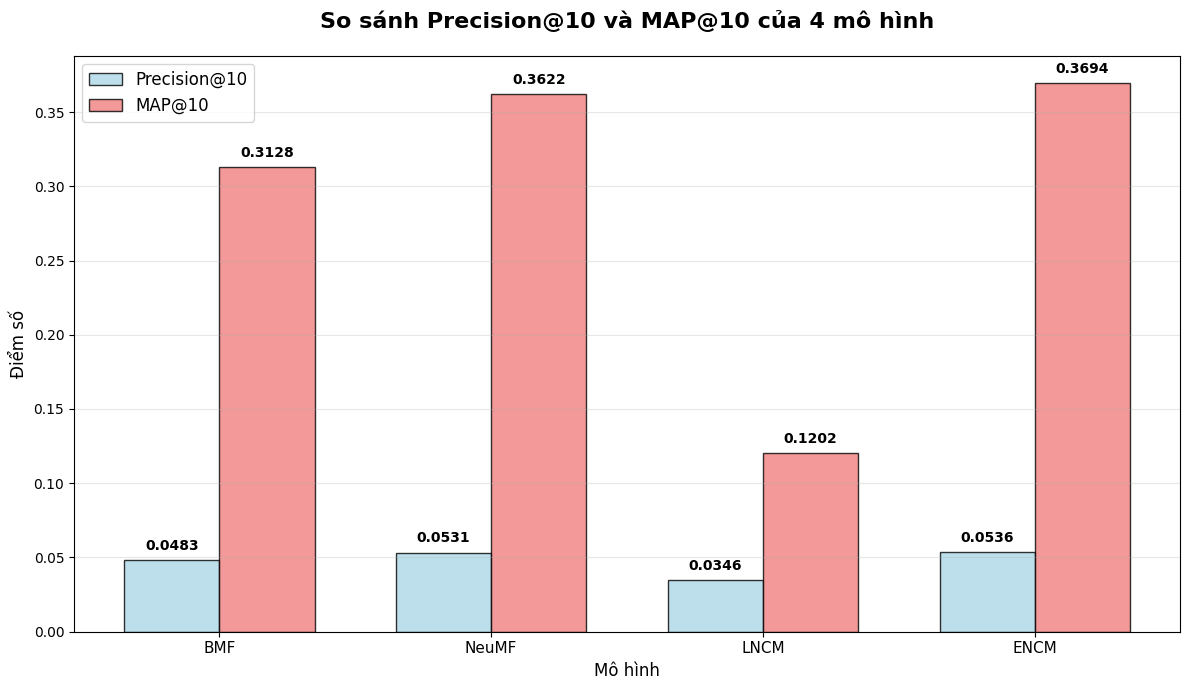


Phân tích kết quả:
Mô hình tốt nhất Precision@10: ENCM (0.0536)
Mô hình tốt nhất MAP@10: ENCM (0.3694)
Mô hình tệ nhất Precision@10: LNCM (0.0346)
Mô hình tệ nhất MAP@10: LNCM (0.1202)

Khoảng cách Precision@10: 0.0190
Khoảng cách MAP@10: 0.2492


In [92]:
# Vẽ biểu đồ so sánh Precision@10 và MAP@10
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('default')

# Chuẩn bị dữ liệu
models = results_loo['model'].tolist()
precision = results_loo['Precision@10'].tolist()
map_scores = results_loo['MAP@10'].tolist()

# Tạo biểu đồ cột nhóm
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))

# Vẽ cột Precision@10
bars1 = ax.bar(x - width/2, precision, width, label='Precision@10', 
               color='lightblue', alpha=0.8, edgecolor='black', linewidth=1)

# Vẽ cột MAP@10
bars2 = ax.bar(x + width/2, map_scores, width, label='MAP@10', 
               color='lightcoral', alpha=0.8, edgecolor='black', linewidth=1)

# Thêm giá trị trên cột
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.005, 
            f'{height:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.005, 
            f'{height:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Cấu hình biểu đồ
ax.set_title('So sánh Precision@10 và MAP@10 của 4 mô hình', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Mô hình', fontsize=12)
ax.set_ylabel('Điểm số', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=11)
ax.legend(fontsize=12)
ax.grid(axis='y', alpha=0.3)

# Thêm đường lưới ngang
ax.yaxis.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Phân tích kết quả
best_precision_model = models[np.argmax(precision)]
best_map_model = models[np.argmax(map_scores)]
worst_precision_model = models[np.argmin(precision)]
worst_map_model = models[np.argmin(map_scores)]

print("\nPhân tích kết quả:")
print(f"Mô hình tốt nhất Precision@10: {best_precision_model} ({max(precision):.4f})")
print(f"Mô hình tốt nhất MAP@10: {best_map_model} ({max(map_scores):.4f})")
print(f"Mô hình tệ nhất Precision@10: {worst_precision_model} ({min(precision):.4f})")
print(f"Mô hình tệ nhất MAP@10: {worst_map_model} ({min(map_scores):.4f})")

# Tính sự khác biệt
precision_range = max(precision) - min(precision)
map_range = max(map_scores) - min(map_scores)
print(f"\nKhoảng cách Precision@10: {precision_range:.4f}")
print(f"Khoảng cách MAP@10: {map_range:.4f}")

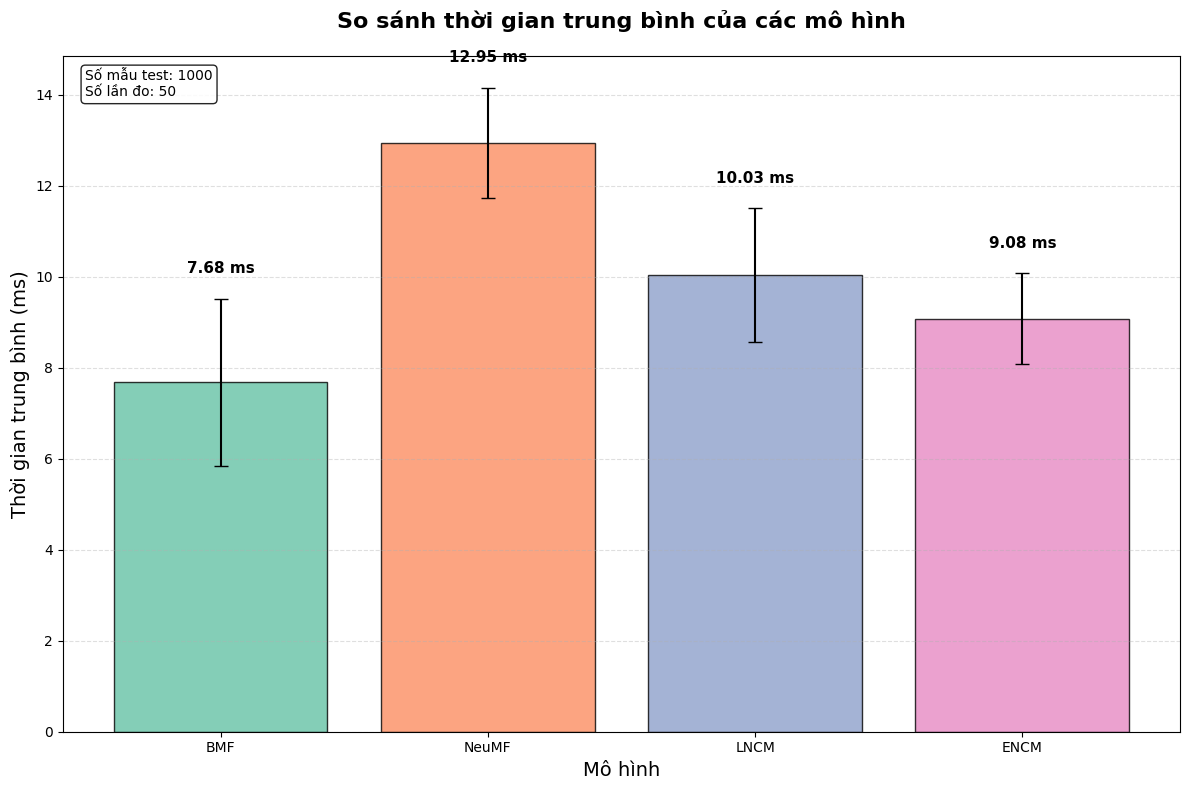

In [93]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ cột với thanh sai số
fig, ax = plt.subplots(figsize=(12, 8))

# Chuẩn bị dữ liệu
models = results_df['Model'].tolist()
avg_times = results_df['avg_time'].tolist()
std_times = results_df['std_time'].tolist()

# Tạo màu tự động theo số mô hình
colors = plt.cm.Set2(range(len(models)))

# Vẽ cột
bars = ax.bar(
    models,
    avg_times,
    yerr=std_times,
    capsize=5,
    color=colors,
    alpha=0.8,
    edgecolor='black',
    linewidth=1
)

# Thêm giá trị trên cột
for bar, avg_time, std_time in zip(bars, avg_times, std_times):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + std_time + 0.5,
        f'{avg_time:.2f} ms',
        ha='center',
        va='bottom',
        fontweight='bold',
        fontsize=11
    )

# Cấu hình biểu đồ
ax.set_title(
    'So sánh thời gian trung bình của các mô hình',
    fontsize=16,
    fontweight='bold',
    pad=20
)
ax.set_xlabel('Mô hình', fontsize=14)
ax.set_ylabel('Thời gian trung bình (ms)', fontsize=14)

ax.grid(axis='y', linestyle='--', alpha=0.4)

# Thêm thông tin chi tiết
ax.text(
    0.02,
    0.98,
    f'Số mẫu test: {n_test_samples}\nSố lần đo: {n_measurements}',
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.85)
)

plt.tight_layout()
plt.show()
